In [ ]:
import glob
import os
import webdataset as wds
from tqdm import tqdm
import torch
from functools import partial
import pandas as pd
from bend.utils.set_seed import SEED
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

N_SHUFFLES = 30
BEND_SHARD_SIZE = 50000
BEND_BUFFER_SIZE = 200
SPLIT = 'train'
MAX_WORKERS = 16

task = 'cpg_methylation'
model = 'hyenadna-tiny-1k'
data_dir = f'../../data/'

embedding_dir = f'{data_dir}/{task}/{model}/'
annotations_path = f'{data_dir}/{task}/{task}.bed'


def iterate_webdataset(tars, shardshuffle=True, buffer_size=None,num_workers=0):
    sample_ids = []

    if shardshuffle:
        shardshuffle = len(tars)

    dataset = wds.WebDataset(tars, shardshuffle=shardshuffle)
    if buffer_size is not None:
        dataset = dataset.shuffle(buffer_size)
    
    dataloader = wds.WebLoader(dataset, num_workers=num_workers, batch_size=None)

    for idx, sample in enumerate(dataloader):
        sample_ids.append(int(sample['__key__'].replace('sample_', '')))
    
    return np.array(sample_ids)

def get_tars(tar_dir, split=SPLIT):
    tars = glob.glob(os.path.join('./', str(tar_dir), "*.tar.gz"))
    tars = [x for x in tars if os.path.split(x)[-1].startswith(split)]

    return tars


def create_shards(gt_idxs, shard_size):
    shards = [gt_idxs[i:i + shard_size] for i in range(0, len(gt_idxs), shard_size)]
    output_dir = f'./shards_{shard_size}/'
    os.makedirs(output_dir, exist_ok=True)

    for idx, shard in tqdm(enumerate(shards)):
        output_path = os.path.join(output_dir, f'{SPLIT}_{idx}.tar.gz')
        if os.path.exists(output_path):
            continue

        sink = wds.TarWriter(output_path, compress=True)
        for sample_id in shard:
            sample = {'__key__': f'sample_{sample_id}', 'idx.npy': np.array(sample_id)}
            sink.write(sample)
        sink.close()

    return get_tars(output_dir, split=SPLIT)

def melt_results(results):
    results_df = pd.DataFrame.from_dict(results)

    results_df = results_df.melt(var_name='shuffle_method', value_name='spearman_correlation')
    results_df['spearman_correlation'] = abs(results_df['spearman_correlation'])
    sorter = results_df.groupby('shuffle_method').median().sort_values(by='spearman_correlation', ascending=True).index

    results_df['shuffle_method'] = results_df['shuffle_method'].astype('category')
    results_df['shuffle_method'] = results_df['shuffle_method'].cat.set_categories(sorter)

    return results_df

/Users/dgreco2/miniconda3/envs/bend/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/Users/dgreco2/miniconda3/envs/bend/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


# Evaluating shuffling 'fairness'

Each shuffling type will contribute to change the order in which the supervised model will ingest samples. To evaluate how the impact of the shuffling types, we compute the new sample order and compare it to the ordered list. The higher the difference, in terms of Spearman's Correlation, the 'fairer' the shuffling.

In [45]:
results = {}

def eval_shuffle(gt_idxs, shuffle_func, n_shuffles=N_SHUFFLES, **kwargs):
    
    correlations = []

    for idx in tqdm(range(n_shuffles)):
        shuffled_idxs = shuffle_func(**kwargs)
        corr = spearmanr(gt_idxs, shuffled_idxs)[0]
        correlations.append(corr)

    return correlations

In [27]:
df = pd.read_csv(annotations_path, sep='\t', low_memory=False)
df = df[df['split'] == SPLIT].reset_index(drop=True)

gt_idxs = df.index.values
gt_idxs

array([     0,      1,      2, ..., 743092, 743093, 743094])

In [43]:
def no_shuffle():
    return df.index.values

results['no_shuffle'] = eval_shuffle(gt_idxs, no_shuffle)

100%|██████████| 30/30 [00:00<00:00, 40.57it/s]


## Shuffle annotations - Dataset level shuffling

In [42]:
def shuffle_annotations(df: pd.DataFrame):
    return df.sample(frac=1).index.values

results['shuffle_annotations'] = eval_shuffle(gt_idxs, shuffle_annotations, df=df)

100%|██████████| 30/30 [00:02<00:00, 11.62it/s]


## Replicate shuffling applied by BEND

#### Optimise computations by storing only sample keys

In [46]:
bend_tars = create_shards(gt_idxs, BEND_SHARD_SIZE)
bend_tars

15it [00:00, 16889.81it/s]


['././shards_50000/train_11.tar.gz',
 '././shards_50000/train_1.tar.gz',
 '././shards_50000/train_13.tar.gz',
 '././shards_50000/train_3.tar.gz',
 '././shards_50000/train_7.tar.gz',
 '././shards_50000/train_9.tar.gz',
 '././shards_50000/train_5.tar.gz',
 '././shards_50000/train_0.tar.gz',
 '././shards_50000/train_10.tar.gz',
 '././shards_50000/train_2.tar.gz',
 '././shards_50000/train_12.tar.gz',
 '././shards_50000/train_6.tar.gz',
 '././shards_50000/train_8.tar.gz',
 '././shards_50000/train_14.tar.gz',
 '././shards_50000/train_4.tar.gz']

### BEND shuffling

In [47]:
results['BEND'] = eval_shuffle(gt_idxs, iterate_webdataset, tars=bend_tars, buffer_size=BEND_BUFFER_SIZE, num_workers=0)

100%|██████████| 30/30 [34:55<00:00, 69.85s/it]


#### Shuffle entire shard in-memory

In [48]:
results['max in-memory'] = eval_shuffle(gt_idxs, iterate_webdataset, tars=bend_tars, buffer_size=BEND_SHARD_SIZE, num_workers=0)

100%|██████████| 30/30 [35:17<00:00, 70.59s/it]


#### Add multiprocessing shuffling

In [49]:
results['max multiprocessing'] = eval_shuffle(gt_idxs, iterate_webdataset, tars=bend_tars, buffer_size=BEND_BUFFER_SIZE, num_workers=len(bend_tars))

100%|██████████| 30/30 [20:47<00:00, 41.60s/it]


#### Combine multiprocessing with entire shard in-memory shuffling

In [50]:
results['in-memory + multiprocessing'] = eval_shuffle(gt_idxs, iterate_webdataset, tars=bend_tars, buffer_size=BEND_SHARD_SIZE, num_workers=len(bend_tars))

100%|██████████| 30/30 [19:47<00:00, 39.57s/it]


## Results

In [ ]:
filename = f'./results_{SPLIT}_BEND.csv'

if os.path.exists(filename):
    results_df = pd.read_csv(filename)
else:
    results_df = melt_results(results)
    results_df.to_csv(filename, index=False)

results_df.describe()

,spearman_correlation
count,120.000000
mean,0.146717
std,0.154011
min,0.021647
25%,0.022443
50%,0.044038
75%,0.241312
max,0.608974


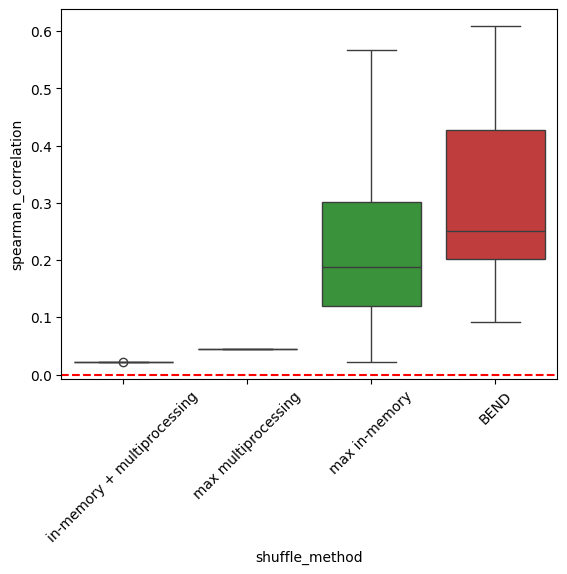

In [52]:
sns.boxplot(data=results_df, x='shuffle_method', y='spearman_correlation', hue='shuffle_method')
plt.axhline(y=0, color='red', linestyle='--')
plt.tick_params(axis='x', labelrotation=45)

## Different shard number

In [ ]:
chunk_results = {}

for shard_size in [100, 1000, 50000, 250000]:
    tars = create_shards(gt_idxs, shard_size)
    
    buffer_size = shard_size if shard_size < BEND_BUFFER_SIZE else BEND_BUFFER_SIZE
    num_workers = 1
    
    chunk_results[f'{shard_size} shard'] = eval_shuffle(gt_idxs, iterate_webdataset, tars=tars,  buffer_size=buffer_size, num_workers=num_workers)

7431it [00:00, 361987.79it/s]
100%|██████████| 30/30 [41:22<00:00, 82.74s/it]
744it [00:00, 176892.59it/s]
100%|██████████| 30/30 [50:46<00:00, 101.55s/it]
15it [00:00, 16630.86it/s]
100%|██████████| 30/30 [51:24<00:00, 102.82s/it]
3it [00:00, 2425.39it/s]
100%|██████████| 30/30 [51:49<00:00, 103.65s/it]


In [ ]:
filename_chunks = f'./results_chunks_{SPLIT}_BEND.csv'

if os.path.exists(filename_chunks):
    results_chunks_df = pd.read_csv(filename_chunks)
else:
    results_chunks_df = melt_results(chunk_results)
    results_chunks_df.to_csv(filename_chunks, index=False)

results_chunks_df

,shuffle_method,spearman_correlation
0,100 shard,0.001762
1,100 shard,0.003700
2,100 shard,0.007644
3,100 shard,0.008084
4,100 shard,0.000460
...,...,...
115,250000 shard,1.000000
116,250000 shard,1.000000
117,250000 shard,0.561807
118,250000 shard,0.320713


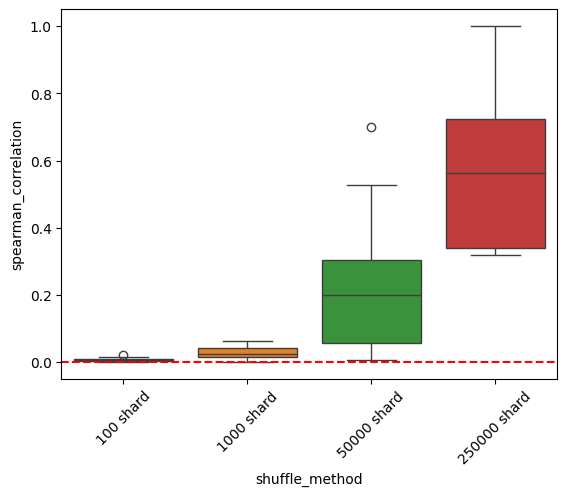

In [53]:
sns.boxplot(data=results_chunks_df, x='shuffle_method', y='spearman_correlation', hue='shuffle_method')
plt.axhline(y=0, color='red', linestyle='--')
plt.tick_params(axis='x', labelrotation=45)